In [160]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [127]:
class z24Dataset(Dataset):
    def __init__(self, window_size=100, skipstep=50, lookahead=1, include_environmental_data=False):
        self.window_size = window_size
        self.skipstep = skipstep
        self.lookahead = lookahead
        self.include_environmental_data = include_environmental_data        
        self.index_file = np.loadtxt('../data/z24/name_to_index.txt',dtype=str)
        self.name_index_dict = dict(zip(range(len(self.index_file)),list(self.index_file)))
        #self.slices_per_file  = 65536//self.skipstep if (self.window_size+self.lookahead) < self.skipstep else \
        #                       (65536//self.skipstep) - (self.window_size+self.lookahead)
        self.slices_per_file = (65536-(self.window_size+self.lookahead))//self.skipstep
    def __len__(self):
        return len(self.index_file) * self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        file_to_read = self.name_index_dict[index_to_read]
        index_in_dataframe = index - index_to_read*self.slices_per_file
        
        df_list = []
        for end in ['03','05','06', '07', '10', '12', '14', '16']:
            df = pd.read_csv('../data/z24/permanent/'+file_to_read+end+'.aaa', 
                             sep=' ',
                             header=None,
                             nrows=self.window_size+self.lookahead, 
                             skiprows=index_in_dataframe+2)
            df.columns = [end]    
            df_list.append(df)
        data = pd.concat(df_list, axis=1).as_matrix()
        
        X = data[:-self.lookahead,:]
        Y = data[-self.lookahead:,:] ##################################wrong
        return X, Y

In [128]:
test = z24Dataset(window_size=500, skipstep=250, lookahead=10)


In [152]:
dataloader = DataLoader(test, batch_size=100,
                        shuffle=True, num_workers=2)

In [153]:
%%time
X_batch, Y_batch = next(iter(dataloader))

CPU times: user 9 ms, sys: 20 ms, total: 29 ms
Wall time: 4.43 s


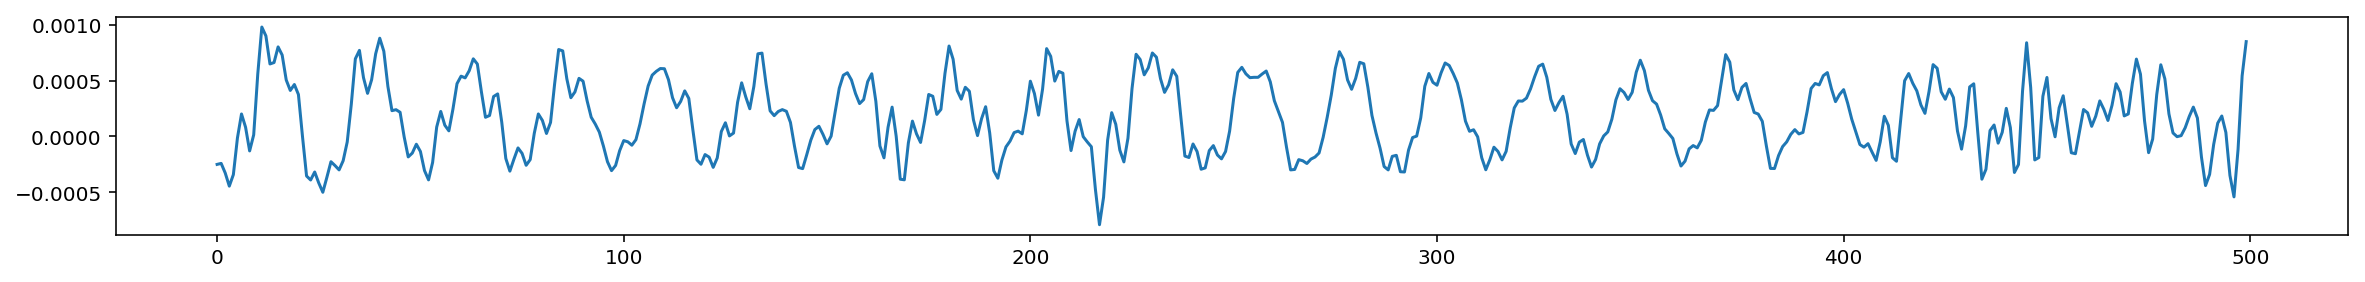

In [170]:
plt.figure(figsize=(20,2))
plt.plot(X_batch[30].numpy()[:,5])

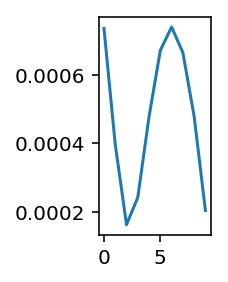

In [171]:
plt.figure(figsize=(1,2))
plt.plot(Y_batch[30].numpy()[:,5])